# NYC Crimes severity prediction

## Import libraries

In [6]:
# Import numpy, pandas, matpltlib.pyplot, sklearn modules and seaborn
import numpy as np
import pandas as pd
import joblib
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# Import LightGBM Classifier
import lightgbm as lgbm
# Import XGBoost Classifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

import scikitplot as skplt

## Data selection

In [12]:
# Import the data
df = pd.read_csv('ny_clean.csv')
print(df.info())


C:\Users\seles\AppData\Local\Temp\ipykernel_11000\120012255.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ny_clean.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7811066 entries, 0 to 7811065
Data columns (total 23 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         object 
 1   year               int64  
 2   month              int64  
 3   day                int64  
 4   weekday            object 
 5   hour               int64  
 6   Latitude           float64
 7   Longitude          float64
 8   CRM_ATPT_CPTD_CD   object 
 9   OFNS_DESC          object 
 10  ADDR_PCT_CD        float64
 11  CRIME_CLASS        object 
 12  BORO_NM            object 
 13  PREM_TYP_DESC      object 
 14  IN_PARK            int64  
 15  IN_PUBLIC_HOUSING  int64  
 16  IN_STATION         int64  
 17  SUSP_AGE_GROUP     object 
 18  SUSP_RACE          object 
 19  SUSP_SEX           object 
 20  VIC_AGE_GROUP      object 
 21  VIC_RACE           object 
 22  VIC_SEX            object 
dtypes: float64(3), int64(7), object(13)
memory usage: 1.3+ GB
None


C:\Users\seles\AppData\Local\Temp\ipykernel_11000\120012255.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.LAW_CAT_CD = df['CRIME_CLASS'].replace(['FELONY','MISDEMEANOR',"VIOLATION"],[2,1,0])


In [17]:
# Convert the Event time and category of the crime to a more representatble data.
df['EVENT_TIME'] = df.hour
df['LAW_CAT_CD'] = df['CRIME_CLASS'].replace(['FELONY','MISDEMEANOR',"VIOLATION"],[2,1,0])

In [18]:
df.columns

Index(['CMPLNT_NUM', 'year', 'month', 'day', 'weekday', 'hour', 'Latitude',
       'Longitude', 'CRM_ATPT_CPTD_CD', 'OFNS_DESC', 'ADDR_PCT_CD',
       'CRIME_CLASS', 'BORO_NM', 'PREM_TYP_DESC', 'IN_PARK',
       'IN_PUBLIC_HOUSING', 'IN_STATION', 'SUSP_AGE_GROUP', 'SUSP_RACE',
       'SUSP_SEX', 'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX', 'EVENT_TIME',
       'LAW_CAT_CD'],
      dtype='object')

In [3]:
df.head()

,EVENT_TIME,year,month,day,Latitude,Longitude,CRM_ATPT_CPTD_CD,OFNS_DESC,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,PREM_TYP_DESC,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,17,2014,9,4,40.685041,-73.921777,COMPLETED,ASSAULT 3 & RELATED OFFENSES,81.0,1,BROOKLYN,STREET,0,0,0,UNKNOWN,UNKNOWN,U,25-44,WHITE,F
1,7,2016,10,12,40.636991,-74.134093,COMPLETED,GRAND LARCENY,121.0,2,STATEN ISLAND,STREET,0,0,0,UNKNOWN,BLACK,U,45-64,WHITE HISPANIC,F
2,13,2012,9,28,40.823876,-73.891863,COMPLETED,GRAND LARCENY,41.0,2,BRONX,STREET,0,0,0,UNKNOWN,WHITE HISPANIC,M,45-64,WHITE HISPANIC,F
3,15,2015,3,24,40.845707,-73.910398,COMPLETED,PETIT LARCENY,46.0,1,BRONX,STREET,0,0,0,UNKNOWN,BLACK,M,<18,WHITE HISPANIC,F
4,4,2017,5,20,40.763992,-73.828426,COMPLETED,ASSAULT 3 & RELATED OFFENSES,109.0,1,QUEENS,STREET,0,0,0,25-44,WHITE HISPANIC,M,25-44,BLACK,M


In [19]:
# Count the number of row in each category
df.LAW_CAT_CD.value_counts().sort_values(ascending=False)

1    4360957
2    2414965
0    1035144
Name: CRIME_CLASS, dtype: int64

In [20]:
# As the data is not balanced, we want create a new balanced dataset that contains 817326 row of each class
zero,one,two = [],[],[]
zero_c,one_c,two_c = 0,0,0
for i in tqdm(df.iterrows()):
    if i[1].LAW_CAT_CD == 0 and zero_c <= 817326:
        zero.append(i[1].values)
        zero_c += 1
    elif i[1].LAW_CAT_CD == 1 and one_c <= 817326:
        one.append(i[1].values)
        one_c += 1
    elif i[1].LAW_CAT_CD == 2 and two_c <= 817326:
        two.append(i[1].values)
        two_c += 1
    if zero_c == 817326 and one_c == 817326 and two_c == 817326:
        break
zero_df = pd.DataFrame(zero, columns=df.columns.values.tolist())
one_df = pd.DataFrame(one, columns=df.columns.values.tolist())
two_df = pd.DataFrame(two, columns=df.columns.values.tolist())
final_df = pd.concat([zero_df,one_df,two_df])
final_df.to_csv("ny_clean_train_balanced.csv",index=False)

7811066it [11:14, 11583.50it/s]


### Import the balanced dataset

In [21]:
# Import the data
df = pd.read_csv('ny_clean_train_balanced.csv')

C:\Users\seles\AppData\Local\Temp\ipykernel_11000\2973783355.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ny_clean_train_balanced.csv')


In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451981 entries, 0 to 2451980
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CMPLNT_NUM         object 
 1   year               int64  
 2   month              int64  
 3   day                int64  
 4   weekday            object 
 5   hour               int64  
 6   Latitude           float64
 7   Longitude          float64
 8   CRM_ATPT_CPTD_CD   object 
 9   OFNS_DESC          object 
 10  ADDR_PCT_CD        float64
 11  CRIME_CLASS        object 
 12  BORO_NM            object 
 13  PREM_TYP_DESC      object 
 14  IN_PARK            int64  
 15  IN_PUBLIC_HOUSING  int64  
 16  IN_STATION         int64  
 17  SUSP_AGE_GROUP     object 
 18  SUSP_RACE          object 
 19  SUSP_SEX           object 
 20  VIC_AGE_GROUP      object 
 21  VIC_RACE           object 
 22  VIC_SEX            object 
 23  EVENT_TIME         int64  
 24  LAW_CAT_CD         int64  
dtypes: float64(3), int

,CMPLNT_NUM,year,month,day,weekday,hour,Latitude,Longitude,CRM_ATPT_CPTD_CD,OFNS_DESC,ADDR_PCT_CD,CRIME_CLASS,BORO_NM,PREM_TYP_DESC,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,EVENT_TIME,LAW_CAT_CD
0,10363948,2006,2,11,Saturday,17,40.698474,-73.917769,COMPLETED,HARRASSMENT 2,83.0,VIOLATION,BROOKLYN,STREET,1,1,1,18-24,BLACK,M,18-24,BLACK,F,17,0
1,71601562,2010,2,13,Saturday,2,40.753533,-73.994537,COMPLETED,HARRASSMENT 2,14.0,VIOLATION,MANHATTAN,STREET,1,1,1,25-44,BLACK,M,18-24,BLACK,F,2,0
2,71315200,2010,2,13,Saturday,21,40.887314,-73.847272,COMPLETED,HARRASSMENT 2,47.0,VIOLATION,BRONX,RESIDENCE - APT. HOUSE,1,1,1,UNKNOWN,BLACK,M,45-64,BLACK,M,21,0
3,151590883,2016,3,23,Wednesday,18,40.671360,-73.881811,COMPLETED,HARRASSMENT 2,75.0,VIOLATION,BROOKLYN,STREET,1,1,1,25-44,BLACK,M,45-64,BLACK,F,18,0
4,192198562,2019,1,8,Tuesday,21,40.822271,-73.911698,COMPLETED,HARRASSMENT 2,42.0,VIOLATION,BRONX,OTHER,1,1,1,UNKNOWN,BLACK,M,45-64,BLACK,M,21,0


In [23]:
# Define a utility function to reduce memory usage by convert the values types
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
df = reduce_mem_usage(df)

Memory usage after optimization is: 280.61 MB
Decreased by 40.0%


## Data preparing

### Select only relevant columns
 

In [25]:
# Set the list of features to include in Machine Learning Model
feature_lst=['EVENT_TIME','ADDR_PCT_CD', 'month', 'day', 'Latitude',
       'Longitude', 'BORO_NM',
       'IN_PARK', 'IN_PUBLIC_HOUSING', 'IN_STATION', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX','LAW_CAT_CD']

df_sel=df[feature_lst].copy()
df_sel.info()
df_sel.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451981 entries, 0 to 2451980
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   EVENT_TIME         int8   
 1   ADDR_PCT_CD        float16
 2   month              int8   
 3   day                int8   
 4   Latitude           float16
 5   Longitude          float16
 6   BORO_NM            object 
 7   IN_PARK            int8   
 8   IN_PUBLIC_HOUSING  int8   
 9   IN_STATION         int8   
 10  VIC_AGE_GROUP      object 
 11  VIC_RACE           object 
 12  VIC_SEX            object 
 13  LAW_CAT_CD         int8   
dtypes: float16(3), int8(7), object(4)
memory usage: 105.2+ MB


,EVENT_TIME,ADDR_PCT_CD,month,day,Latitude,Longitude,BORO_NM,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,LAW_CAT_CD
0,17,83.0,2,11,40.68750,-73.9375,BROOKLYN,1,1,1,18-24,BLACK,F,0
1,2,14.0,2,13,40.75000,-74.0000,MANHATTAN,1,1,1,18-24,BLACK,F,0
2,21,47.0,2,13,40.87500,-73.8750,BRONX,1,1,1,45-64,BLACK,M,0
3,18,75.0,3,23,40.65625,-73.8750,BROOKLYN,1,1,1,45-64,BLACK,F,0
4,21,42.0,1,8,40.81250,-73.9375,BRONX,1,1,1,45-64,BLACK,M,0


In [26]:
print(df_sel.shape)
# double check that the data is balanced
df_sel.LAW_CAT_CD.value_counts().sort_values(ascending=False)

(2451981, 14)


0    817327
1    817327
2    817327
Name: LAW_CAT_CD, dtype: int64

C:\Users\seles\AppData\Local\Temp\ipykernel_11000\2905963049.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_sel.corr()


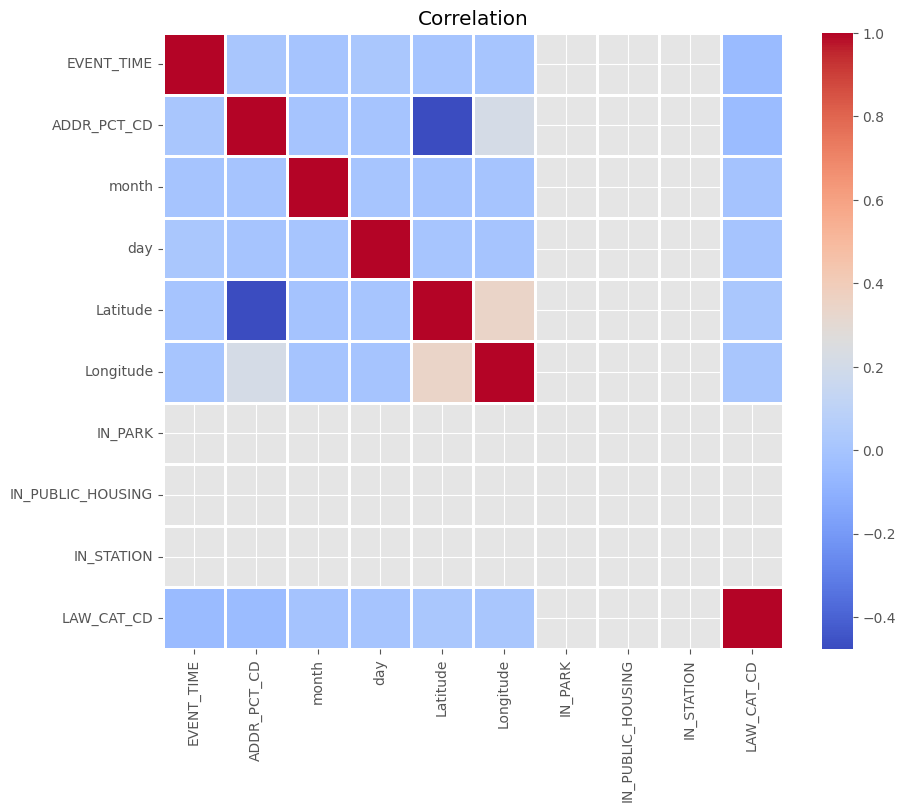

In [27]:
# Draw a corrolation matrix of the variables
corr = df_sel.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr, cmap = "coolwarm", linewidth = 2, linecolor = "white")
plt.title("Correlation")
plt.show()

### Deal with categorical data: pd.get_dummies()

In [28]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_sel)

df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451981 entries, 0 to 2451980
Data columns (total 36 columns):
 #   Column                                   Dtype  
---  ------                                   -----  
 0   EVENT_TIME                               int8   
 1   ADDR_PCT_CD                              float16
 2   month                                    int8   
 3   day                                      int8   
 4   Latitude                                 float16
 5   Longitude                                float16
 6   IN_PARK                                  int8   
 7   IN_PUBLIC_HOUSING                        int8   
 8   IN_STATION                               int8   
 9   LAW_CAT_CD                               int8   
 10  BORO_NM_(null)                           uint8  
 11  BORO_NM_BRONX                            uint8  
 12  BORO_NM_BROOKLYN                         uint8  
 13  BORO_NM_MANHATTAN                        uint8  
 14  BORO_NM_QUEENS    

In [29]:
df_state_dummy.head()

,EVENT_TIME,ADDR_PCT_CD,month,day,Latitude,Longitude,IN_PARK,IN_PUBLIC_HOUSING,IN_STATION,LAW_CAT_CD,BORO_NM_(null),BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,VIC_AGE_GROUP_18-24,VIC_AGE_GROUP_25-44,VIC_AGE_GROUP_45-64,VIC_AGE_GROUP_65+,VIC_AGE_GROUP_<18,VIC_AGE_GROUP_UNKNOWN,VIC_RACE_(null),VIC_RACE_AMERICAN INDIAN/ALASKAN NATIVE,VIC_RACE_ASIAN / PACIFIC ISLANDER,VIC_RACE_BLACK,VIC_RACE_BLACK HISPANIC,VIC_RACE_OTHER,VIC_RACE_UNKNOWN,VIC_RACE_WHITE,VIC_RACE_WHITE HISPANIC,VIC_SEX_(null),VIC_SEX_D,VIC_SEX_E,VIC_SEX_F,VIC_SEX_M
0,17,83.0,2,11,40.68750,-73.9375,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,2,14.0,2,13,40.75000,-74.0000,1,1,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,21,47.0,2,13,40.87500,-73.8750,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,18,75.0,3,23,40.65625,-73.8750,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,21,42.0,1,8,40.81250,-73.9375,1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### Split the data into train and test

In [30]:
# Assign the data
df=df_state_dummy

# Set the target for the prediction
target='LAW_CAT_CD'

# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

In [31]:
y.unique()
y.value_counts()

0    817327
1    817327
2    817327
Name: LAW_CAT_CD, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=21, stratify=y)

## Utils

In [33]:
def plot_cm(y_pred,y_test,algorithm,figure_name):
    mat_RF = confusion_matrix(y_pred,y_test)
    plt.figure(figsize=(16,4))
    sns.heatmap(mat_RF, square=True, annot=True, fmt='d', cbar=False,xticklabels=[0,1,2],yticklabels=[0,1,2])
    plt.xlabel('True labels')
    plt.ylabel('predicted labels')
    plt.title(algorithm)
    plt.savefig(figure_name)

In [34]:
def plot_roc(y_test, model, figure_name):
    pl = skplt.metrics.plot_roc(y_test, model.predict_proba(X_test), figsize=(12,6))
    plt.show()
    pl.figure.savefig(figure_name)

In [35]:
def save_model(model, model_name,is_tree=False):
    joblib.dump(model.estimators_[0] if is_tree else model,f'{model_name}.joblib')
    print(f"Model size: {np.round(os.path.getsize(f'{model_name}.joblib') / 1024 / 1024, 2) } MB")

## Modeling: Random Forest

In [36]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=1)

#Train the model using the training sets
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Get the accuracy score
acc_rf = accuracy_score(y_test, y_pred)

# Get classification report
class_report = classification_report(y_test, y_pred)

# Model Accuracy, how often is the classifier correct?
print("[Random forest algorithm] accuracy_score: {:.3f}.".format(acc_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   47.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.8min finished


[Random forest algorithm] accuracy_score: 0.446.


In [37]:
print(class_report)

              precision    recall  f1-score   support

           0       0.47      0.53      0.50    163465
           1       0.44      0.40      0.42    163466
           2       0.42      0.41      0.42    163466

    accuracy                           0.45    490397
   macro avg       0.44      0.45      0.44    490397
weighted avg       0.44      0.45      0.44    490397



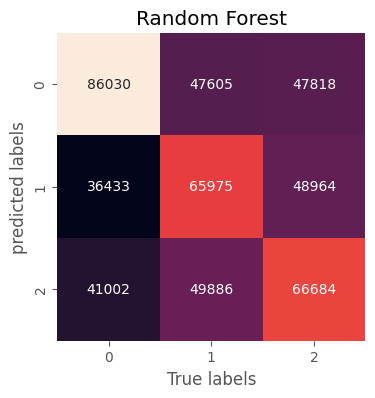

In [38]:
# Plot confusion matrix
plot_cm(y_pred,y_test,"Random Forest","cm_random_forest.pdf")

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   41.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.7min finished


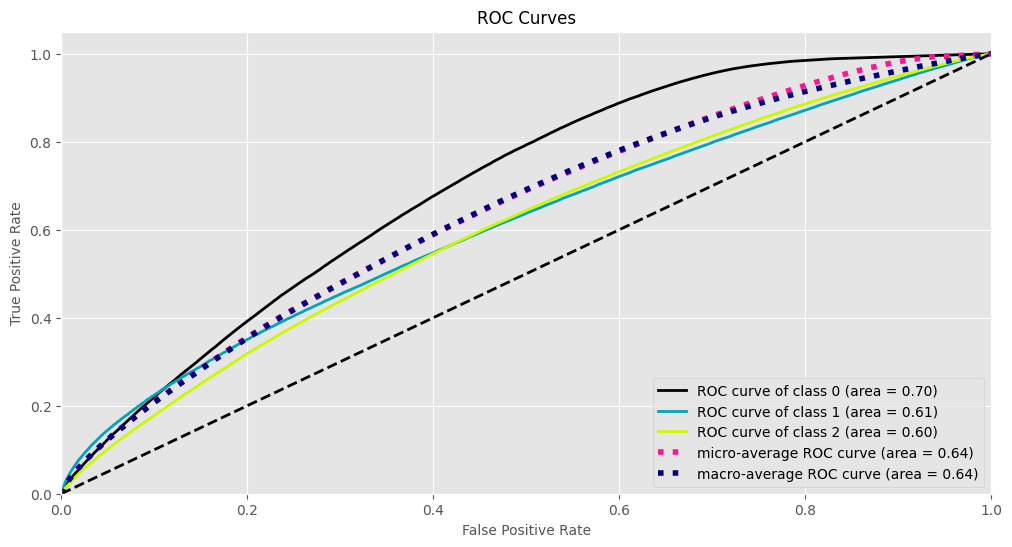

In [39]:
# Plot ROC curve
plot_roc(y_test,clf,"roc_random_forest.pdf")

In [40]:
# Save model
save_model(clf,"random_forest",True)

Model size: 135.01 MB


## Modeling: LightGBM

In [41]:
# Define the model hyperparameters
lgbm_params = {
          "boosting_type": "gbdt",
          "learning_rate": 0.1,
          "num_leaves": 20,
          "max_bin": 256,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0,
          "subsample": 0.9}
# Train the model
lbm_clf = lgbm.LGBMClassifier(**lgbm_params)
lbm_clf.fit(X_train,y_train)
# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)

# Get classification report
class_report = classification_report(y_test, y_pred)

print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 1961584, number of used features: 32
[LightGBM] [Info] Start training from score -1.098611
[LightGBM] [Info] Start training from score -1.098613
[LightGBM] [Info] Start training from score -1.098613


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   32.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:  1.4min finished


LightGBM Model accuracy score: 0.4460


In [42]:
print(class_report)

              precision    recall  f1-score   support

           0       0.47      0.53      0.50    163465
           1       0.44      0.40      0.42    163466
           2       0.42      0.41      0.42    163466

    accuracy                           0.45    490397
   macro avg       0.44      0.45      0.44    490397
weighted avg       0.44      0.45      0.44    490397



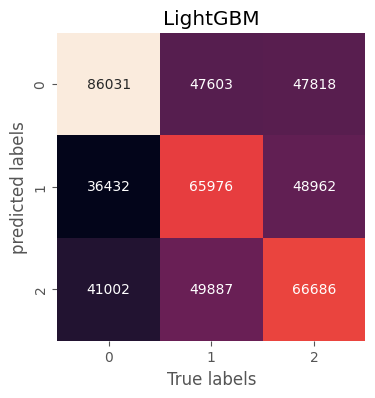

In [43]:
# Plot the confusion matrix
plot_cm(y_pred, y_test, "LightGBM", 'cm_LightGBM.pdf')

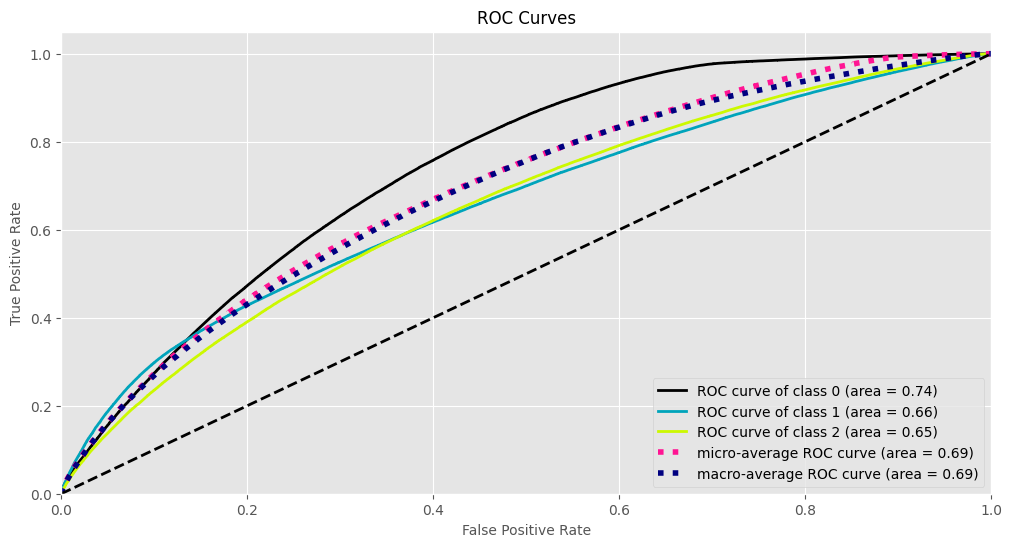

In [44]:
# Plot the ROC curve
plot_roc(y_test, lbm_clf, "roc_LightGBM.pdf")

In [45]:
# Save the model
save_model(lbm_clf, "lightgbm")

Model size: 0.68 MB


## Modeling XGBoost

In [46]:
# Before training the model, we need to remove some special characters from the columns name
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [48]:
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]

In [ ]:
# Define the model hyperparameters
params = {
            'objective':'multi:softmax',
            'max_depth': 10,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100,
            'use_label_encoder':False
        }

# instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)



In [49]:
# test the models performace
y_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('XGBBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

XGBBoost Model accuracy score: 0.5037


In [50]:
# Get classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.49      0.75      0.59    163465
           1       0.56      0.35      0.43    163466
           2       0.49      0.41      0.44    163466

    accuracy                           0.50    490397
   macro avg       0.51      0.50      0.49    490397
weighted avg       0.51      0.50      0.49    490397



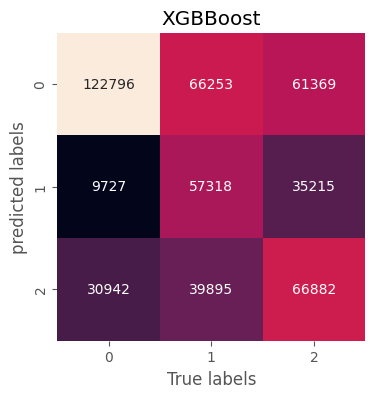

In [51]:
# Plot the confusion matrix
plot_cm(y_pred, y_test, "XGBBoost", 'cm_XGBBoost.pdf')

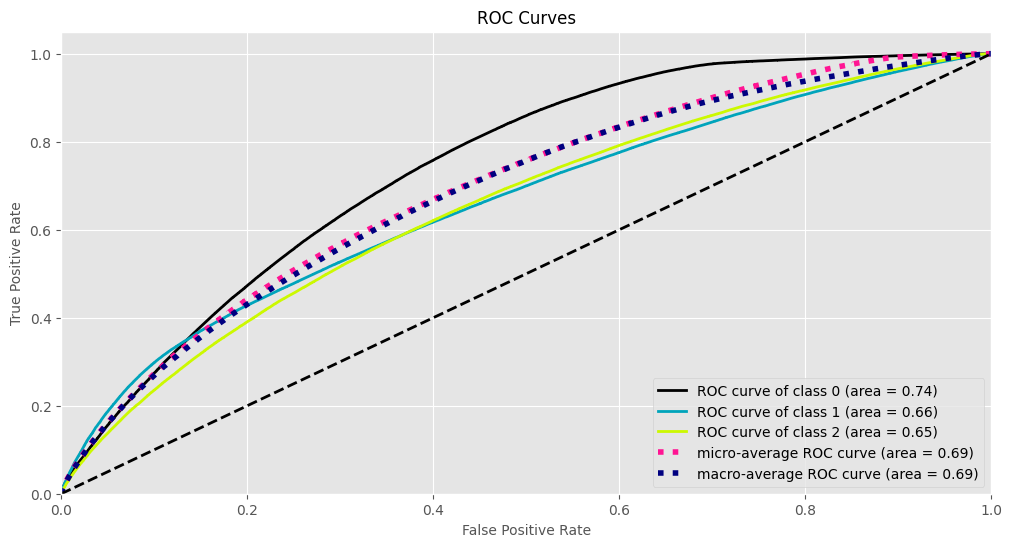

In [52]:
# Plot the ROC curve
plot_roc(y_test, xgb_clf, "roc_XGBBoost.pdf")

In [53]:
# Save the model
save_model(xgb_clf, "xgboost")

Model size: 10.36 MB


# 1.8. Modeling CatBoost

In [55]:
from catboost import CatBoostClassifier
estimator_super = CatBoostClassifier(    
    l2_leaf_reg = 10,
    max_depth = 10,
    n_estimators = 100,
    loss_function = 'MultiClass',  
    use_best_model = True, 
   random_seed = 42) 

estimator_super.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
# cat_predict_proba_super = estimator_super.predict_proba(X_test)
y_pred =  estimator_super.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
print('CatBoost Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost Model accuracy score: 0.4937


In [56]:
# Get classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.48      0.76      0.59    163465
           1       0.56      0.35      0.43    163466
           2       0.47      0.37      0.41    163466

    accuracy                           0.49    490397
   macro avg       0.50      0.49      0.48    490397
weighted avg       0.50      0.49      0.48    490397



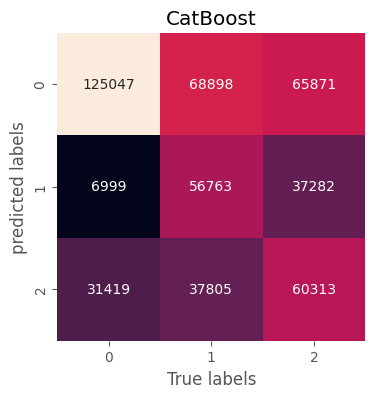

In [57]:
# Plot the confusion matrix
plot_cm(y_pred, y_test, "CatBoost", 'cm_CatBoost.pdf')

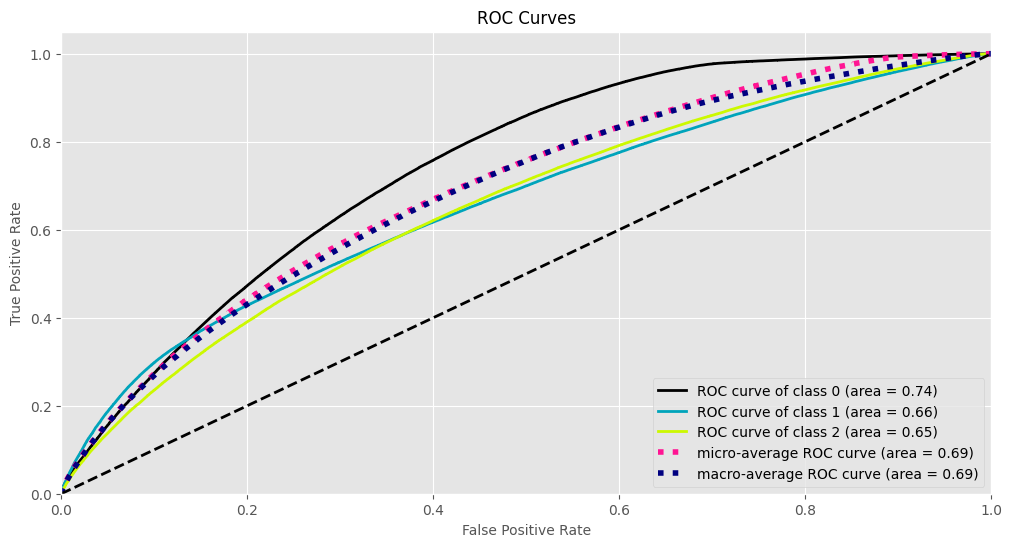

In [58]:
# Plot the ROC curve
plot_roc(y_test, estimator_super, "roc_CatBoost.pdf")

In [ ]:
from hyperopt import hp, fmin, tpe, Trials

dict_of_params = {"n_estimators": [30, 50, 70, 100, 150],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.3],
    "l2_leaf_reg": [1, 3, 5, 7, 9, 10]}
space = {
    'n_estimators': hp.choice('n_estimators', dict_of_params["n_estimators"]),
    'max_depth': hp.choice('max_depth', dict_of_params["max_depth"]),
    'learning_rate': hp.uniform('learning_rate', dict_of_params["learning_rate"][0], dict_of_params["learning_rate"][1]),
    'l2_leaf_reg': hp.choice('l2_leaf_reg', dict_of_params["l2_leaf_reg"])
}

In [ ]:
def objective(cat_features, **params):
    model = CatBoostClassifier(**params, loss_function = 'MultiClass',random_seed = 42)
    model.fit(X_train, y_train, silent=True)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    return score

In [ ]:
trials = Trials()
best = fmin(objective, space, algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
# Получаем лучшие значения гиперпараметров
final_best_params = {}
for key in best:
    try:
        final_best_params[key] = dict_of_params[key][best[key]]
    except:
        final_best_params[key] = best[key]


# Обучаем модель с лучшими гиперпараметрами
model = CatBoostClassifier(**final_best_params,  loss_function = 'MultiClass',random_seed = 42)
model.fit(X_train, y_train, silent=True)


# Предсказываем классы для тестовых данных
y_preda_new = model.predict(X_test)

# Вычисляем точность модели
accuracy_new = accuracy_score(y_test, y_preda_new)

# Выводим результаты
print("Точность модели:", accuracy_new)